In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()
x_test -= x_test.min()
x_test = x_test / x_test.max()

# Build VAE

In [4]:
enc_1 = Dense(100,activation ='sigmoid')
enc_mean = Dense (2)
enc_log_var = Dense(2)

dec_2 = Dense(100,activation ='sigmoid')
dec_1 = Dense(784,activation='sigmoid')

In [5]:
x =Input(shape=(784,))
enc_x =enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [8]:
x_hat = dec_1(dec_2(z))

In [9]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

 Build loss function 

In [10]:
def vae_loss(x,x_recon):
    recovery_loss = 784 *metrics.binary_crossentropy(x,x_recon)
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1)
    return recovery_loss + kl_loss

In [11]:
VAE.compile(loss=vae_loss,optimizer=Adam())
VAE.fit(x_train,x_train,batch_size = 32 ,epochs=100)

Epoch 1/100
60000/60000 [==============================] - 4s 64us/step - loss: 193.9928
Epoch 2/100
60000/60000 [==============================] - 4s 61us/step - loss: 180.1897
Epoch 3/100
60000/60000 [==============================] - 4s 58us/step - loss: 178.0302
Epoch 4/100
60000/60000 [==============================] - 4s 61us/step - loss: 174.1212
Epoch 5/100
60000/60000 [==============================] - 4s 59us/step - loss: 170.1884
Epoch 6/100
60000/60000 [==============================] - 4s 62us/step - loss: 167.4152
Epoch 7/100
60000/60000 [==============================] - 4s 61us/step - loss: 165.6208
Epoch 8/100
60000/60000 [==============================] - 4s 62us/step - loss: 164.1146
Epoch 9/100
60000/60000 [==============================] - 4s 60us/step - loss: 162.8762
Epoch 10/100
60000/60000 [==============================] - 4s 62us/step - loss: 161.7438
Epoch 11/100
60000/60000 [==============================] - 4s 60us/step - loss: 160.6221
Epoch 12/100
60000/

60000/60000 [==============================] - 4s 62us/step - loss: 144.1969
Epoch 93/100
60000/60000 [==============================] - 4s 61us/step - loss: 144.1500
Epoch 94/100
60000/60000 [==============================] - 4s 61us/step - loss: 144.1119
Epoch 95/100
60000/60000 [==============================] - 4s 61us/step - loss: 144.0727
Epoch 96/100
60000/60000 [==============================] - 4s 61us/step - loss: 143.9959
Epoch 97/100
60000/60000 [==============================] - 4s 61us/step - loss: 144.0210
Epoch 98/100
60000/60000 [==============================] - 4s 62us/step - loss: 144.0244
Epoch 99/100
60000/60000 [==============================] - 4s 62us/step - loss: 143.9364
Epoch 100/100
60000/60000 [==============================] - 4s 62us/step - loss: 143.8404


# VAE Encoder

In [12]:
VAE_encoder = Model(x, z_mean)

VAE_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


# VAE Decoder

In [13]:
h_input = Input(shape=(2, ))
VAE_decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [14]:
indices = np.random.randint(x_test.shape[0], size=2000)
VAE_latent=VAE_encoder.predict(x_test[indices])


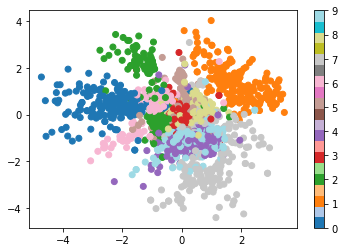

In [15]:
#plt.figure(figsize=(10, 10))
plt.scatter(VAE_latent[:, 0], VAE_latent[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [16]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [17]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

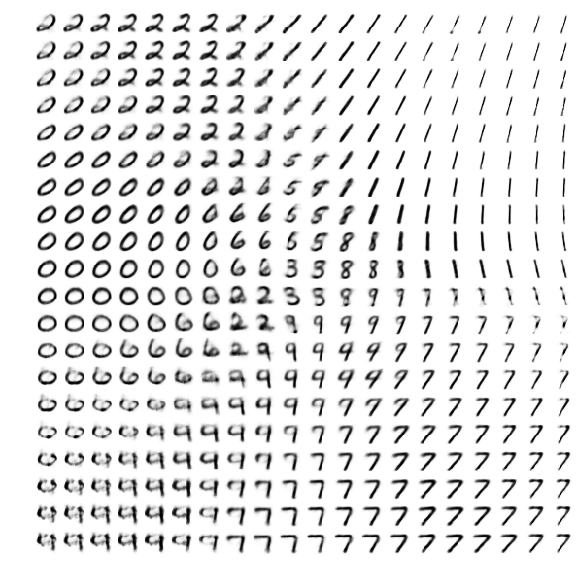

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# Dynamic display

In [21]:
idx_1, idx_2 = np.random.randint(1000, size=2)
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='inferno')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [22]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.01,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>